# Spikes and Bursts Detection, Classification, and Visualization

 This section of the notebook processes electrophysiological recordings stored in ABF format.
 The workflow includes:
 1. Loading and concatenating multiple sweeps into one continuous signal.
 2. Detecting spikes using a voltage threshold.
 3. Identifying bursts based on short interspike intervals (ISIs).
 4. Classifying bursts according to their voltage waveform (square-wave, parabolic, or other).
 5. Saving the classified burst data to a CSV file.
 6. Visualizing the raw signal, detected spikes, and bursts of each type.

 The approach follows the spike/burst detection ideas shared by Serafim, 
 adapted here for signal classification and visualization.

 - **Import necessary libraries** 

In [17]:

import pyabf                       # For reading Axon Binary Files (.abf)
import numpy as np                 # For numerical operations
import pandas as pd                # For data handling and exporting results
import matplotlib.pyplot as plt    # For visualization
from scipy.signal import find_peaks # For spike detection
%matplotlib widget      

- **Load and inspect the ABF file**

In [18]:
file_path = "bursting/cell89basal.abf"  # Path to the ABF recording
abf = pyabf.ABF(file_path)              # Load the recording

- **Concatenate all sweeps into a single continuous trace**

Each sweep represents a time segment of the experiment.
We concatenate them to form a single signal covering the entire recording duration.

In [19]:
signal = np.concatenate([abf.setSweep(i) or abf.sweepY for i in range(abf.sweepCount)])

# Compute sampling parameters
dt = 1.0 / abf.dataRate                # Sampling period (s)
time = np.arange(len(signal)) * dt     # Time vector for plotting and indexing

# Display basic recording information
print(f"File: {file_path} | sweeps: {abf.sweepCount} | total length: {time[-1]:.2f} s")

File: bursting/cell89basal.abf | sweeps: 30 | total length: 645.00 s


- **Spike Detection**

Spikes are detected as positive peaks crossing a voltage threshold.
Here, the threshold is set to -35 mV, but it can be adjusted depending on signal characteristics.

In [20]:
threshold = -35  # mV
spike_indices, _ = find_peaks(signal, height=threshold)  # Identify peaks above threshold
spike_times = time[spike_indices]                        # Convert spike indices to time

- **Burst Detection**

Bursts are groups of spikes occurring close in time.
The interspike interval (ISI) is calculated as the time difference between consecutive spikes.
If the ISI is shorter than a chosen threshold, those spikes belong to the same burst.

In [21]:
isi = np.diff(spike_times)            # Compute all ISIs
burst_threshold = 0.3                 # s; defines the maximum gap between spikes within a burst

bursts = []                           # Will store start and end times of each detected burst
current_burst = [spike_times[0]]      # Start with the first spike

# Iterate through all spikes and group them into bursts based on ISI threshold
for i in range(1, len(isi)):
    if isi[i-1] < burst_threshold:            # If the next spike occurs quickly → same burst
        current_burst.append(spike_times[i])
    else:                                     # Otherwise → end current burst
        if len(current_burst) > 1:            # Only consider sequences with 2+ spikes
            bursts.append((current_burst[0], current_burst[-1]))
        current_burst = [spike_times[i]]      # Start a new burst

# Add the final burst if the last group meets the same criteria
if len(current_burst) > 1:
    bursts.append((current_burst[0], current_burst[-1]))

- **Burst Classification**

Each detected burst is classified by comparing its minimum voltage to nearby interburst mean voltages.

 - If the burst minimum is above the interburst mean → "Square Wave" (flatter waveform)
 - If it is below → "Parabolic" (deeper, curved waveform)
 - Otherwise → "Other" (irregular or ambiguous shape)

In [22]:
square_wave_bursts = []
parabolic_bursts = []
other_bursts = []

for i, (burst_start, burst_end) in enumerate(bursts):
    # Create a boolean mask to extract the segment corresponding to the burst
    burst_mask = (time >= burst_start) & (time <= burst_end)
    burst_min = np.min(signal[burst_mask])  # Find the minimum voltage during this burst

    # Calculate mean voltage levels between bursts
    # These represent the baseline or "resting" activity between firing episodes.
    prev_mean = np.mean(signal[(time > bursts[i-1][1]) & (time < burst_start)]) if i > 0 else np.nan
    next_mean = np.mean(signal[(time > burst_end) & (time < bursts[i+1][0])]) if i < len(bursts)-1 else np.nan
    inter_mean = np.nanmean([prev_mean, next_mean])  # Average of the two, ignoring NaNs

    # Classification logic based on relative voltage levels
    if burst_min > inter_mean:
        square_wave_bursts.append((burst_start, burst_end))
    elif burst_min < inter_mean:
        parabolic_bursts.append((burst_start, burst_end))
    else:
        other_bursts.append((burst_start, burst_end))

- **Save Burst Information into a CSV File**

This section organizes the detected bursts and their classifications into a structured format
and saves them as a CSV file for later analysis or comparison.

In [23]:
burst_list = []  # Prepare an empty list that will hold all burst data rows

# Add each burst type to the list, maintaining sequential numbering
# The numbering offsets ensure all bursts (of any type) have unique indices.

# Square-wave bursts
for idx, (start, end) in enumerate(square_wave_bursts):
    burst_list.append([idx+1, start, end, "Square Wave"])

# Parabolic bursts
for idx, (start, end) in enumerate(parabolic_bursts):
    burst_list.append([idx+1+len(square_wave_bursts), start, end, "Parabolic"])

# Other bursts
for idx, (start, end) in enumerate(other_bursts):
    burst_list.append([idx+1+len(square_wave_bursts)+len(parabolic_bursts), start, end, "Other"])

# Convert the list to a DataFrame and define column names
df_bursts = pd.DataFrame(burst_list, columns=["Burst_Number", "Start_Time_s", "End_Time_s", "Type"])

# Export results to a CSV file (easy to load in other analysis tools or scripts)
df_bursts.to_csv("burst_info_cell89.csv", index=False)
print(df_bursts)

     Burst_Number  Start_Time_s  End_Time_s         Type
0               1       76.5200     77.4671  Square Wave
1               2      104.7433    107.4776  Square Wave
2               3      191.0791    193.4927  Square Wave
3               4      207.6007    212.0541  Square Wave
4               5      322.6933    322.8075  Square Wave
..            ...           ...         ...          ...
272           273      632.1943    634.1843    Parabolic
273           274      634.5038    634.7590    Parabolic
274           275      638.2392    638.3164    Parabolic
275           276      638.6217    639.7094    Parabolic
276           277      642.4200    642.5522    Parabolic

[277 rows x 4 columns]


- **Visualization: Plot Spikes and Bursts**

The final plot provides a visual summary of:
 - The raw voltage trace over time.
 - Detected spike positions (red points).
 - Shaded regions representing different burst types.
 
   Blue = Square-wave, Green = Parabolic, Orange = Other.

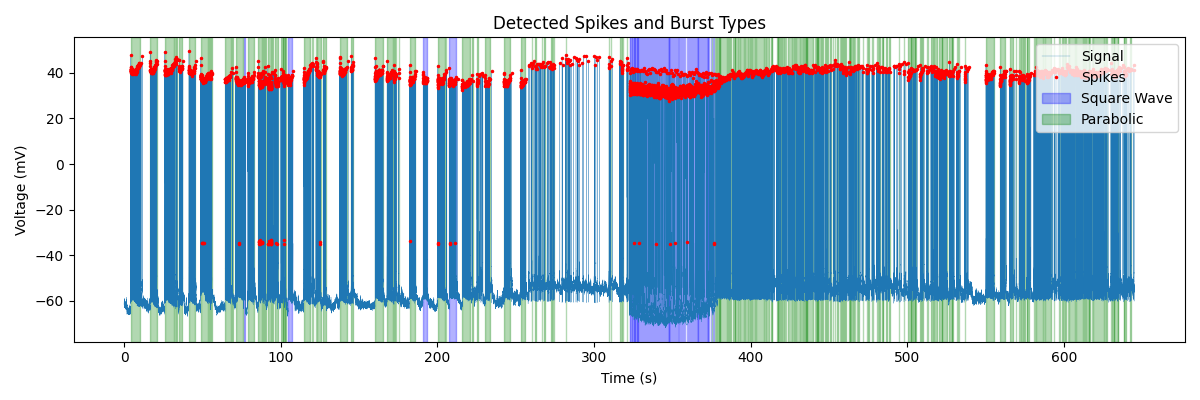

In [24]:
plt.figure(figsize=(12,4))
plt.plot(time, signal, lw=0.2, label='Signal')  # Continuous signal trace
plt.plot(spike_times, signal[spike_indices], 'r.', markersize=3, label='Spikes')  # Spike markers

# Shade the time intervals corresponding to different burst types
for start, end in square_wave_bursts:
    plt.axvspan(start, end, color='blue', alpha=0.3, label='Square Wave' if start == square_wave_bursts[0][0] else "")
for start, end in parabolic_bursts:
    plt.axvspan(start, end, color='green', alpha=0.3, label='Parabolic' if start == parabolic_bursts[0][0] else "")
for start, end in other_bursts:
    plt.axvspan(start, end, color='orange', alpha=0.3, label='Other' if start == other_bursts[0][0] else "")

# Final plot customization
plt.xlabel("Time (s)")
plt.ylabel("Voltage (mV)")
plt.title("Detected Spikes and Burst Types")
plt.legend(loc="upper right", frameon=True)
plt.tight_layout()
plt.show()

# Visibility graphs and 2D and 3D embeddings

- **The main steps are:**
 1. Load electrophysiological signals from ABF recordings.
 2. Detect spikes and group them into bursts.
 3. Compute internal ISIs for each spike within bursts.
 4. Classify bursts into types (Square Wave, Parabolic, or Other).
 5. Build visibility graphs representing internal burst dynamics.
 6. Apply dimensionality reduction (Truncated SVD) to embed graphs into 2D and 3D spaces.
 7. Visualize example bursts and save all data (bursts, nodes, edges) for further analysis.

- **Import required libraries**

In [25]:
import pyabf                         # For loading Axon Binary Files (.abf)
import numpy as np                   # Numerical computations
import pandas as pd                  # Data manipulation and saving CSVs
import matplotlib.pyplot as plt      # Visualization
import networkx as nx                # Graph creation and analysis
from scipy.signal import find_peaks  # Spike detection
from sklearn.decomposition import TruncatedSVD  # Dimensionality reduction
%matplotlib widget                   

- **Load ABF file**

In [26]:
file_path = "bursting/cell89basal.abf"
abf = pyabf.ABF(file_path)

- **Concatenate all sweeps**

Each sweep in the ABF file corresponds to one segment of recording.
We merge all sweeps into one continuous signal for full-session analysis.

In [27]:
signal = np.concatenate([abf.setSweep(i) or abf.sweepY for i in range(abf.sweepCount)])
dt = 1.0 / abf.dataRate  # Sampling period (s)
time = np.arange(len(signal)) * dt   # Time axis

- **Spike Detection**

Spikes are detected as positive peaks crossing a chosen threshold.
Here, spikes above -35 mV are considered.

In [28]:
threshold = -35  # mV
spike_indices, _ = find_peaks(signal, height=threshold)
spike_times = time[spike_indices]  # Convert spike indices to seconds

- **Burst Detection**

Bursts are sequences of spikes that occur close in time.
We use the interspike interval (ISI) to determine grouping:
if two spikes are separated by less than `burst_threshold`, they belong to the same burst.

In [29]:
isi = np.diff(spike_times)
burst_threshold = 0.3  # seconds

bursts = []
current_burst = [0]  # Start with the first spike index

for i in range(1, len(spike_times)):
    if isi[i-1] < burst_threshold:
        current_burst.append(i)
    else:
        if len(current_burst) > 1:
            bursts.append(current_burst)
        current_burst = [i]
if len(current_burst) > 1:
    bursts.append(current_burst)

print(f"Detected {len(bursts)} bursts.")

Detected 278 bursts.


- **Compute Internal ISIs for Each Burst**

For every spike within each burst, compute the local ISI (in milliseconds).
The first spike of each burst has ISI = 0 by definition.

In [30]:
isi_per_spike_burst = np.zeros(len(spike_times))
for burst in bursts:
    for i, idx in enumerate(burst):
        isi_per_spike_burst[idx] = 0 if i == 0 else (spike_times[idx] - spike_times[burst[i-1]]) * 1000  # ms

- **Burst Classification**

Bursts are classified based on their voltage waveform and baseline behavior.
Classification rules (relative to baseline mean voltage):
 - "Square Wave": burst minimum > baseline mean → flat high-voltage shape
 - "Parabolic": burst minimum < baseline mean → deeper curvature
 - "Other": ambiguous or irregular shape

In [31]:
square_wave_bursts, parabolic_bursts, other_bursts = [], [], []
burst_types = {}

for i, burst in enumerate(bursts):
    # Extract segment corresponding to current burst
    burst_mask = (time >= spike_times[burst[0]]) & (time <= spike_times[burst[-1]])
    burst_min = np.min(signal[burst_mask])

    # Compute baseline mean levels before and after the burst
    prev_mean = np.mean(signal[(time > spike_times[bursts[i-1][-1]]) & (time < spike_times[burst[0]])]) if i > 0 else np.nan
    next_mean = np.mean(signal[(time > spike_times[burst[-1]]) & (time < spike_times[bursts[i+1][0]])]) if i < len(bursts)-1 else np.nan
    inter_mean = np.nanmean([prev_mean, next_mean])  # Ignore NaNs if at boundaries

    # Apply classification rule
    if burst_min > inter_mean:
        square_wave_bursts.append(burst)
        burst_types[tuple(burst)] = "Square Wave"
    elif burst_min < inter_mean:
        parabolic_bursts.append(burst)
        burst_types[tuple(burst)] = "Parabolic"
    else:
        other_bursts.append(burst)
        burst_types[tuple(burst)] = "Other"

- **Save Burst Information**

Construct a structured table with burst indices, start and end times, and types.

In [32]:
burst_list = []
for idx, burst in enumerate(bursts):
    burst_type = burst_types[tuple(burst)]
    burst_list.append([idx+1, spike_times[burst[0]], spike_times[burst[-1]], burst_type])

df_bursts_all = pd.DataFrame(burst_list, columns=["Burst_Number", "Start_Time_s", "End_Time_s", "Type"])
df_bursts_all.to_csv("burst_basic_info_cell89_all_bursts.csv", index=False)
print(df_bursts_all.head(10))  # Display first 10 bursts

   Burst_Number  Start_Time_s  End_Time_s       Type
0             1        4.1492     10.4632  Parabolic
1             2       16.7984     21.0475  Parabolic
2             3       25.9975     31.7546  Parabolic
3             4       32.2976     32.6686  Parabolic
4             5       33.2434     33.6903  Parabolic
5             6       35.2539     37.2636  Parabolic
6             7       41.4399     45.3242  Parabolic
7             8       48.8635     53.6932  Parabolic
8             9       54.3833     55.0212  Parabolic
9            10       55.5536     56.1263  Parabolic


- **Visibility Graphs and Embeddings**

 The visibility graph method maps a time series into a graph where:
 - Each spike is a node.
 - Two spikes (nodes) are connected if there is a "line of sight" between them:
   no intermediate spike lies above the straight line connecting them.

 Once the visibility graph is built for each burst:
 - We apply Truncated SVD to reduce the adjacency matrix into 2D and 3D embeddings.
 - The embeddings capture structural relationships between spikes in each burst.

C:\Users\manur\AppData\Local\Temp\ipykernel_26292\3058859153.py:43: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(12,10))


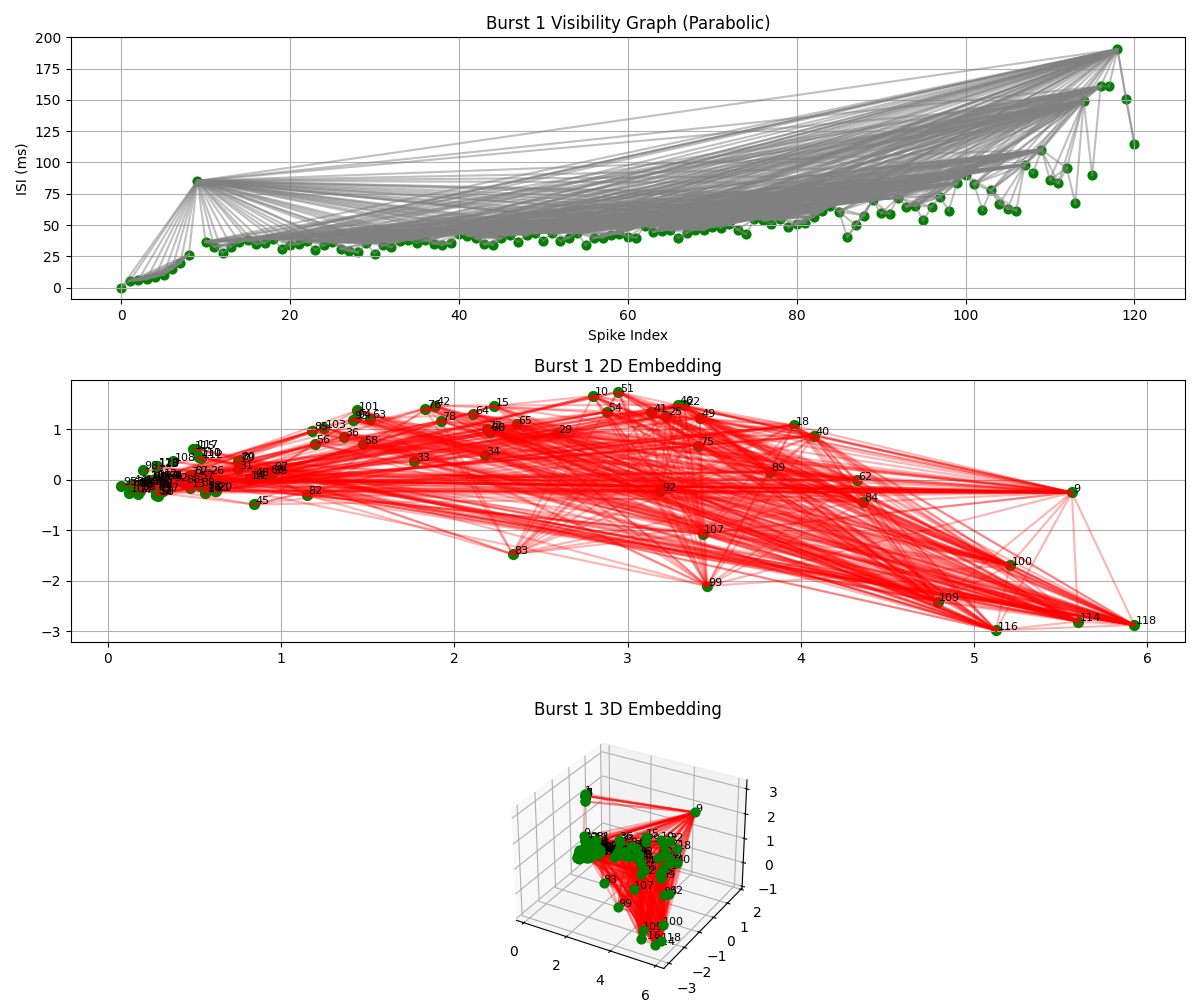

In [ ]:
colors_map = {"Square Wave": "blue", "Parabolic": "green", "Other": "orange"}
nodes_list, edges_list = [], []

for b_idx, burst in enumerate(bursts):
    burst_type = burst_types[tuple(burst)]
    x_peaks = np.arange(len(burst))
    y_peaks = isi_per_spike_burst[burst]

    # Build Visibility Graph 
    G = nx.Graph()
    G.add_nodes_from(range(len(burst)))  # One node per spike
    for a in range(len(x_peaks)):
        for b in range(a+1, len(x_peaks)):
            visible = True
            for c in range(a+1, b):
                # Expected line height between spikes a and b at position c
                y_line = y_peaks[b] + (y_peaks[a] - y_peaks[b]) * (x_peaks[b] - x_peaks[c]) / (x_peaks[b] - x_peaks[a])
                if y_peaks[c] >= y_line:  # If any intermediate spike blocks visibility
                    visible = False
                    break
            if visible:
                G.add_edge(a, b)
                edges_list.append([b_idx+1, burst_type, a, b])

    # Compute Graph Embeddings
    A = nx.to_numpy_array(G)
    n_dim = min(3, A.shape[0])  # Avoid dimension mismatch for small bursts
    embedding_2d = TruncatedSVD(n_components=2, random_state=42).fit_transform(A)
    embedding_3d = TruncatedSVD(n_components=n_dim, random_state=42).fit_transform(A) if n_dim >= 3 else np.zeros((len(burst), 3))

    # Save Node Information 
    for i in range(len(burst)):
        nodes_list.append([
            b_idx+1, burst_type, i,
            embedding_2d[i,0], embedding_2d[i,1],
            embedding_3d[i,0], embedding_3d[i,1], embedding_3d[i,2],
            burst[i]
        ])

    # Visualize the First Few Bursts 
    # Plot visibility graph + embeddings for up to the first 14 bursts for exploration.
    if b_idx < 14:
        fig = plt.figure(figsize=(12,10))

        # Visibility Graph
        ax0 = fig.add_subplot(3,1,1)
        for u, v in G.edges():
            ax0.plot([x_peaks[u], x_peaks[v]], [y_peaks[u], y_peaks[v]], 'gray', alpha=0.5)
        ax0.scatter(x_peaks, y_peaks, color=colors_map[burst_type], s=40)
        ax0.set_title(f"Burst {b_idx+1} Visibility Graph ({burst_type})")
        ax0.set_xlabel("Spike Index")
        ax0.set_ylabel("ISI (ms)")
        ax0.grid(True)

        # 2D Embedding
        ax1 = fig.add_subplot(3,1,2)
        for i in range(len(burst)):
            ax1.scatter(embedding_2d[i,0], embedding_2d[i,1], color=colors_map[burst_type], s=50)
            ax1.text(embedding_2d[i,0]+0.01, embedding_2d[i,1]+0.01, str(i), fontsize=8)
        for u, v in G.edges():
            ax1.plot([embedding_2d[u,0], embedding_2d[v,0]], [embedding_2d[u,1], embedding_2d[v,1]], 'r-', alpha=0.3)
        ax1.set_title(f"Burst {b_idx+1} 2D Embedding")
        ax1.grid(True)

        # 3D Embedding
        if embedding_3d is not None:
            ax2 = fig.add_subplot(3,1,3, projection='3d')
            for i in range(len(burst)):
                ax2.scatter(embedding_3d[i,0], embedding_3d[i,1], embedding_3d[i,2], color=colors_map[burst_type], s=40)
                ax2.text(embedding_3d[i,0], embedding_3d[i,1], embedding_3d[i,2], str(i), fontsize=8)
            for u, v in G.edges():
                ax2.plot([embedding_3d[u,0], embedding_3d[v,0]],
                         [embedding_3d[u,1], embedding_3d[v,1]],
                         [embedding_3d[u,2], embedding_3d[v,2]], 'r-', alpha=0.3)
            ax2.set_title(f"Burst {b_idx+1} 3D Embedding")

        plt.tight_layout()
        plt.show()

- **Save Graph Data (Nodes and Edges)**

 Two tables are saved:
 - `burst_nodes_all.csv` → Each node with its coordinates and global spike index
 - `burst_edges_all.csv` → Each edge representing a visibility connection

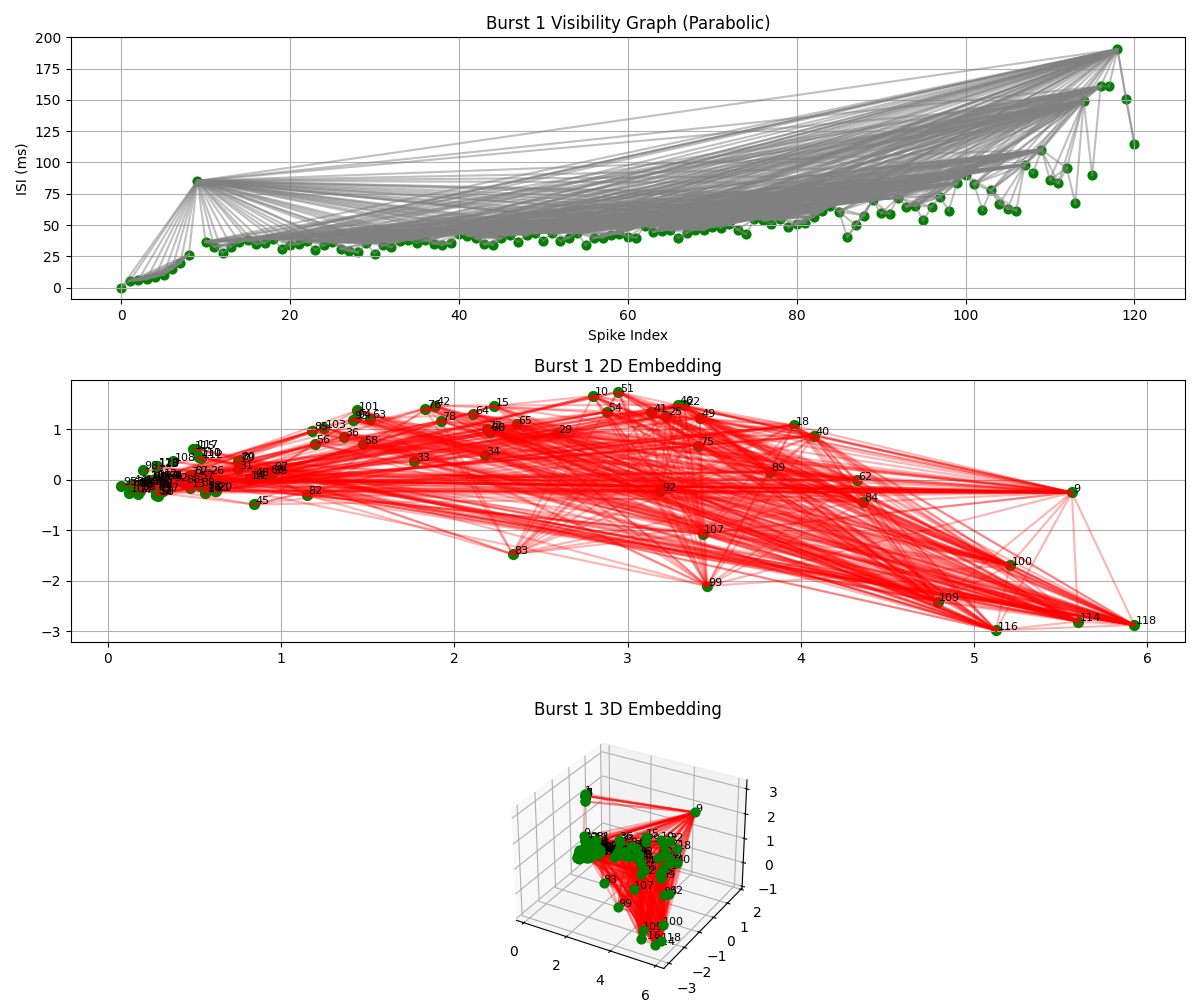

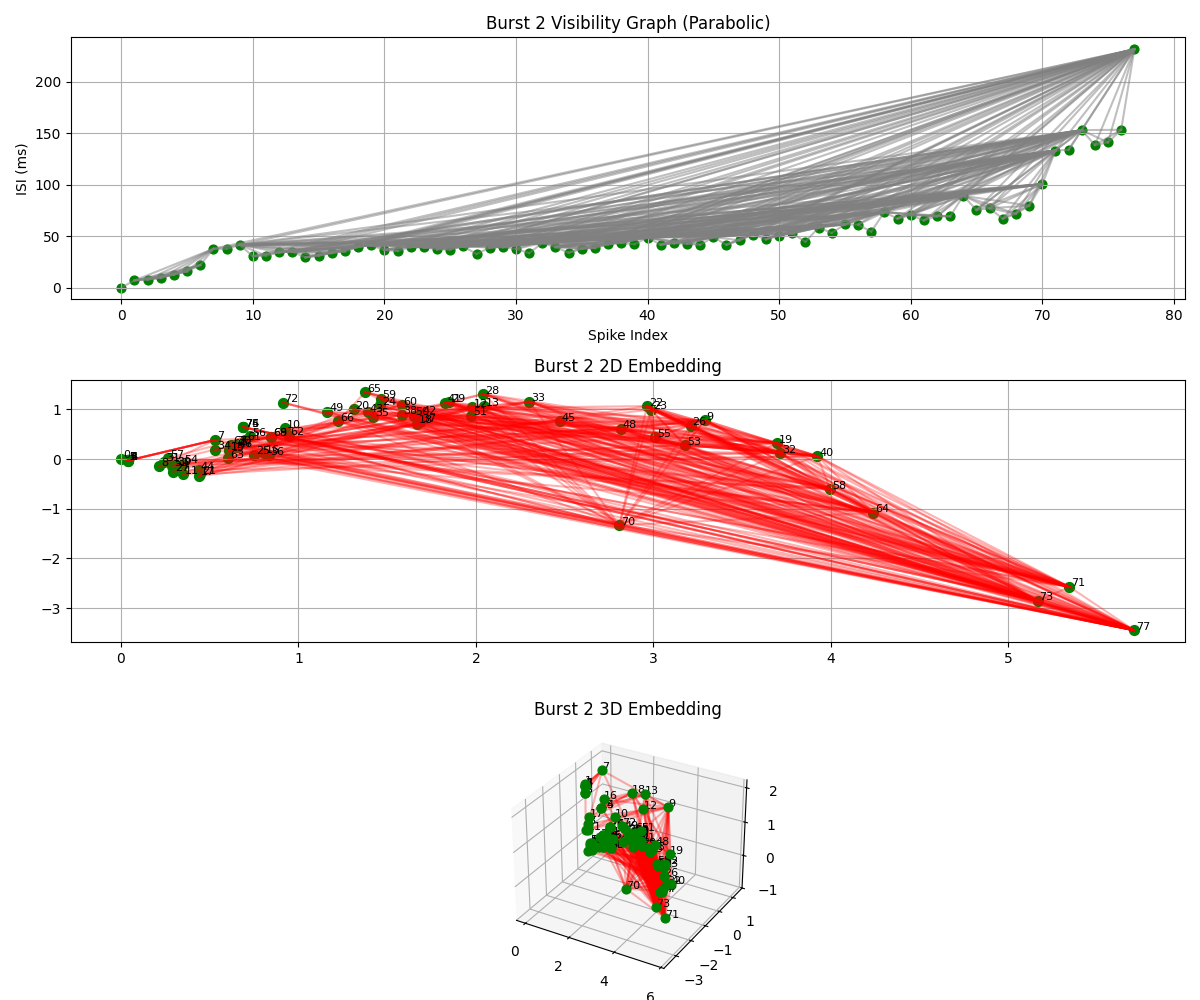

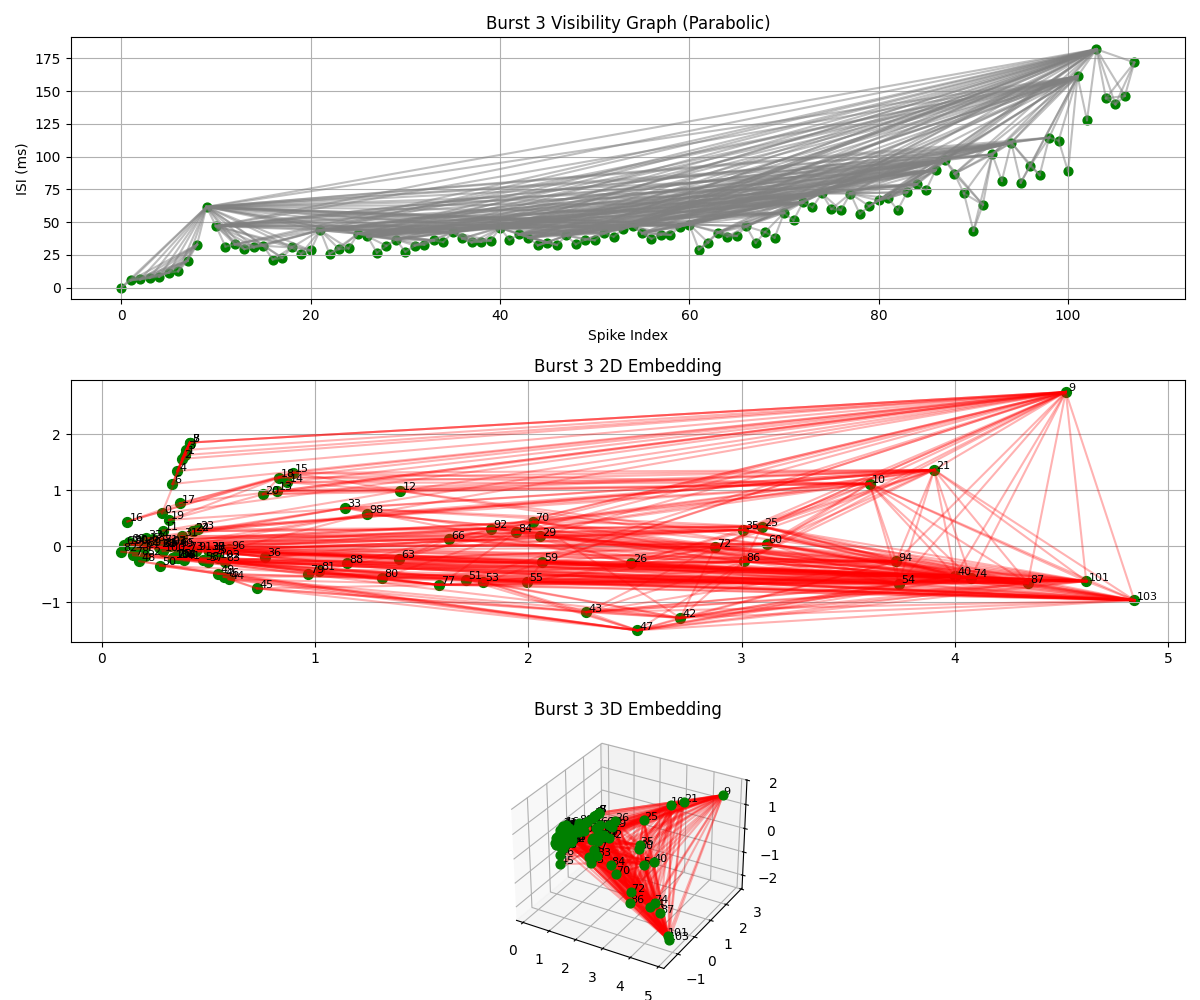

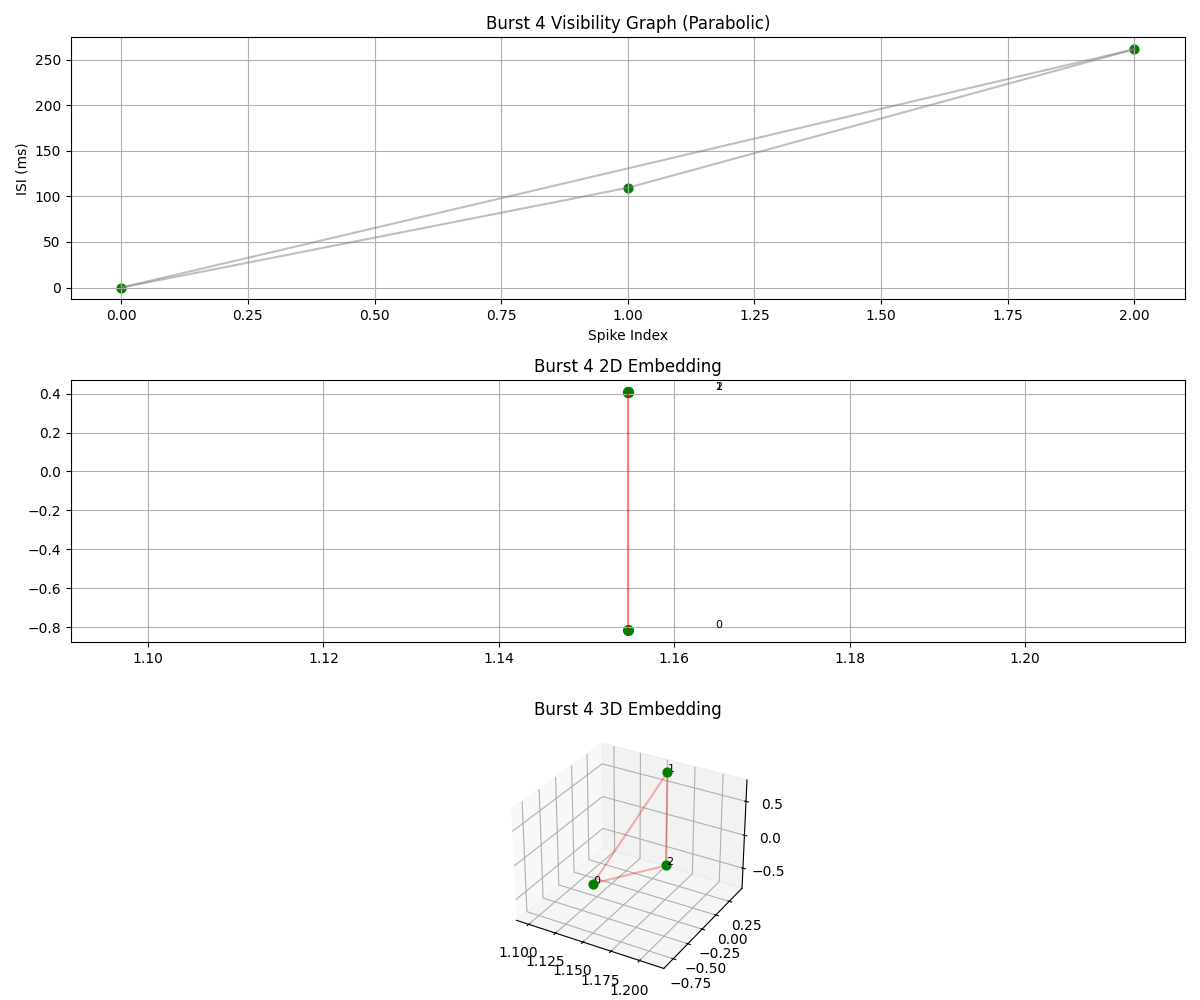

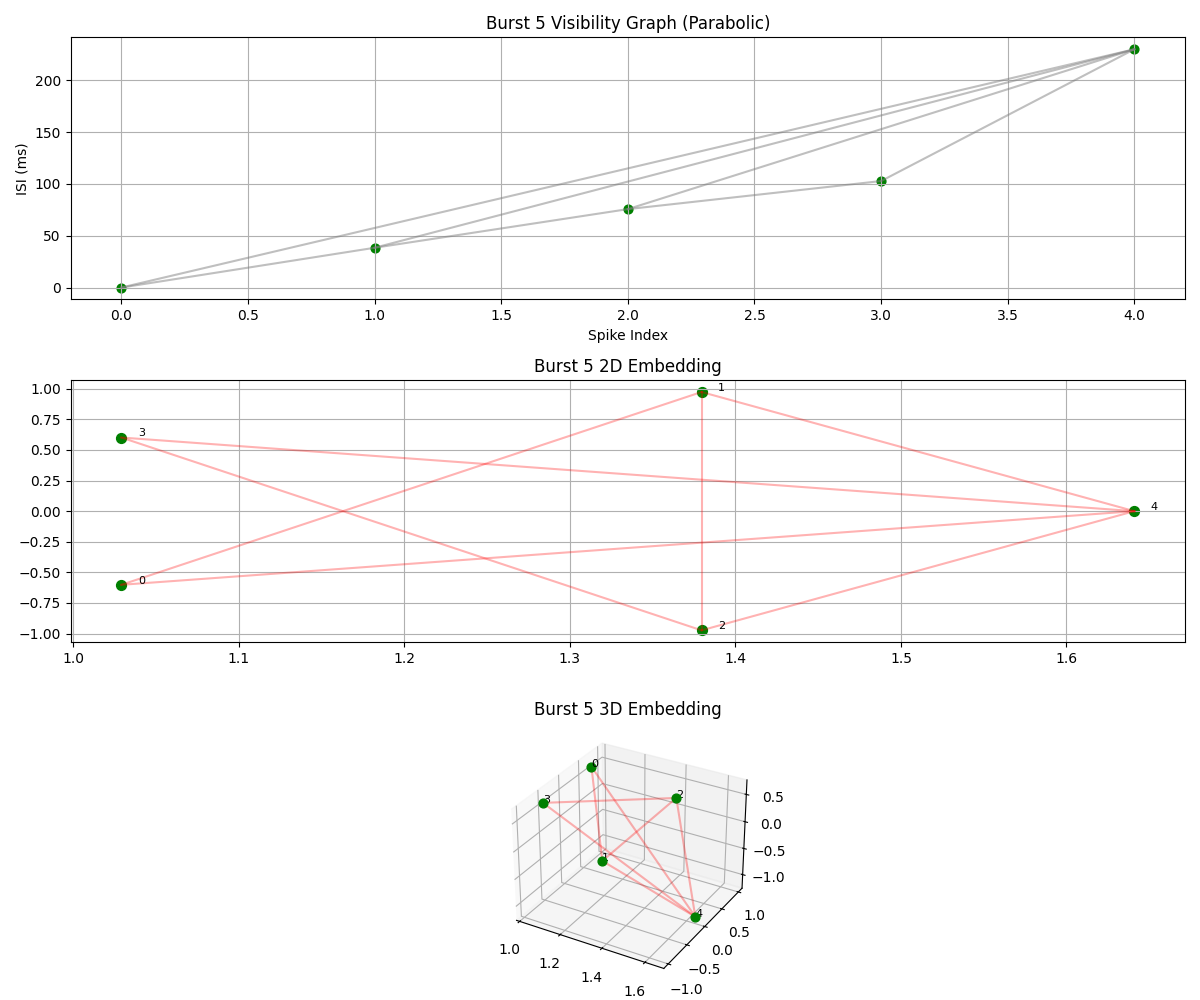

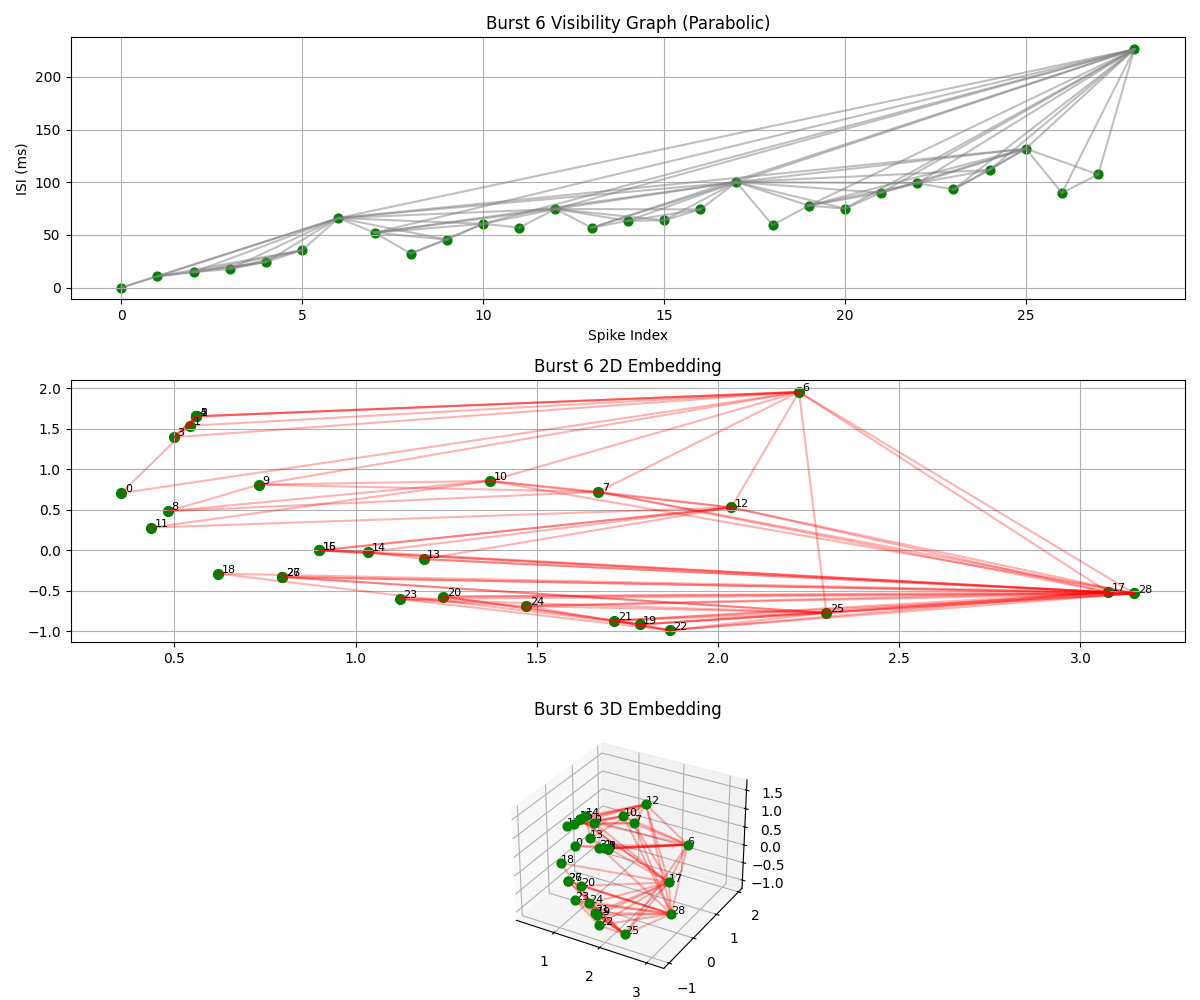

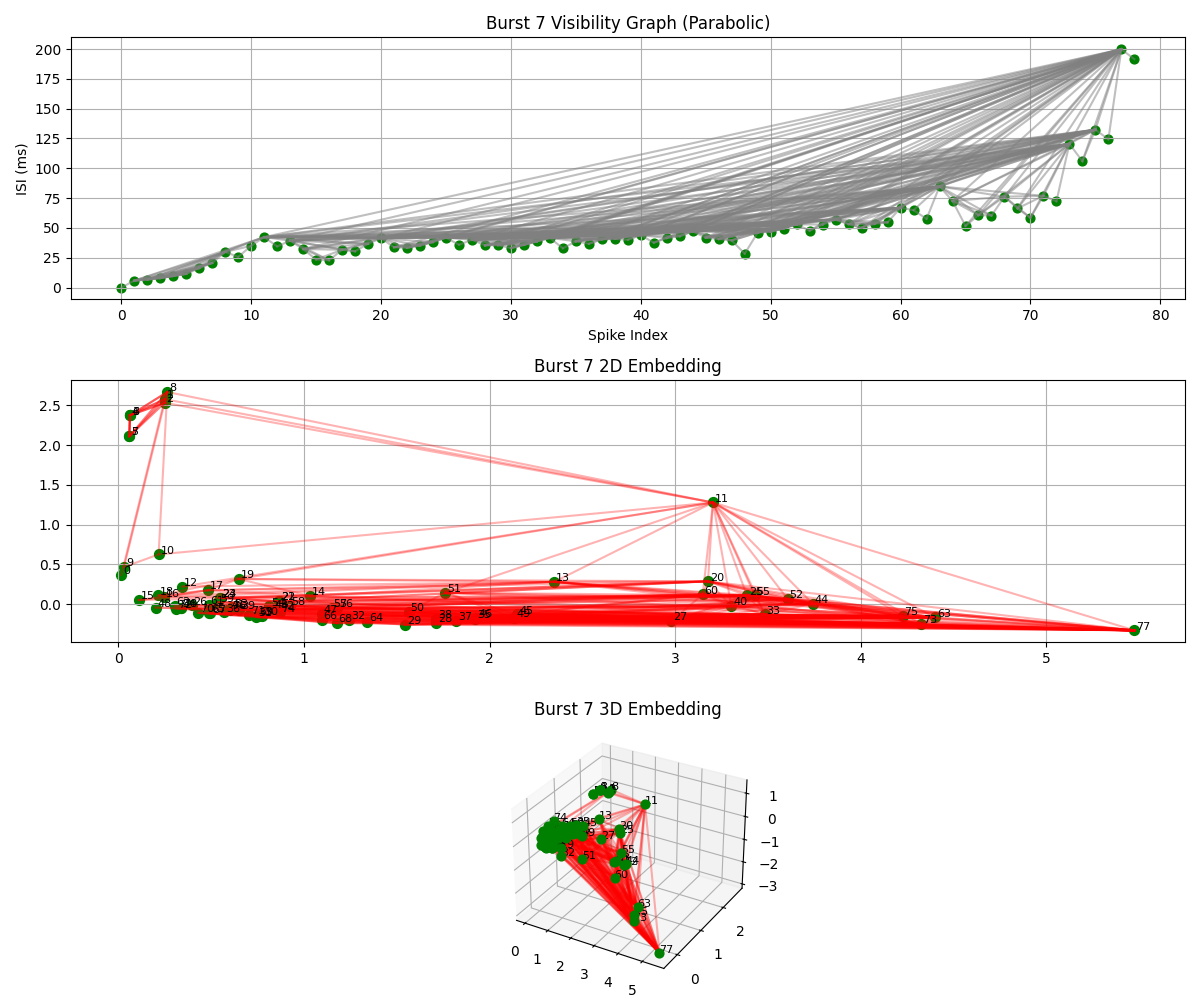

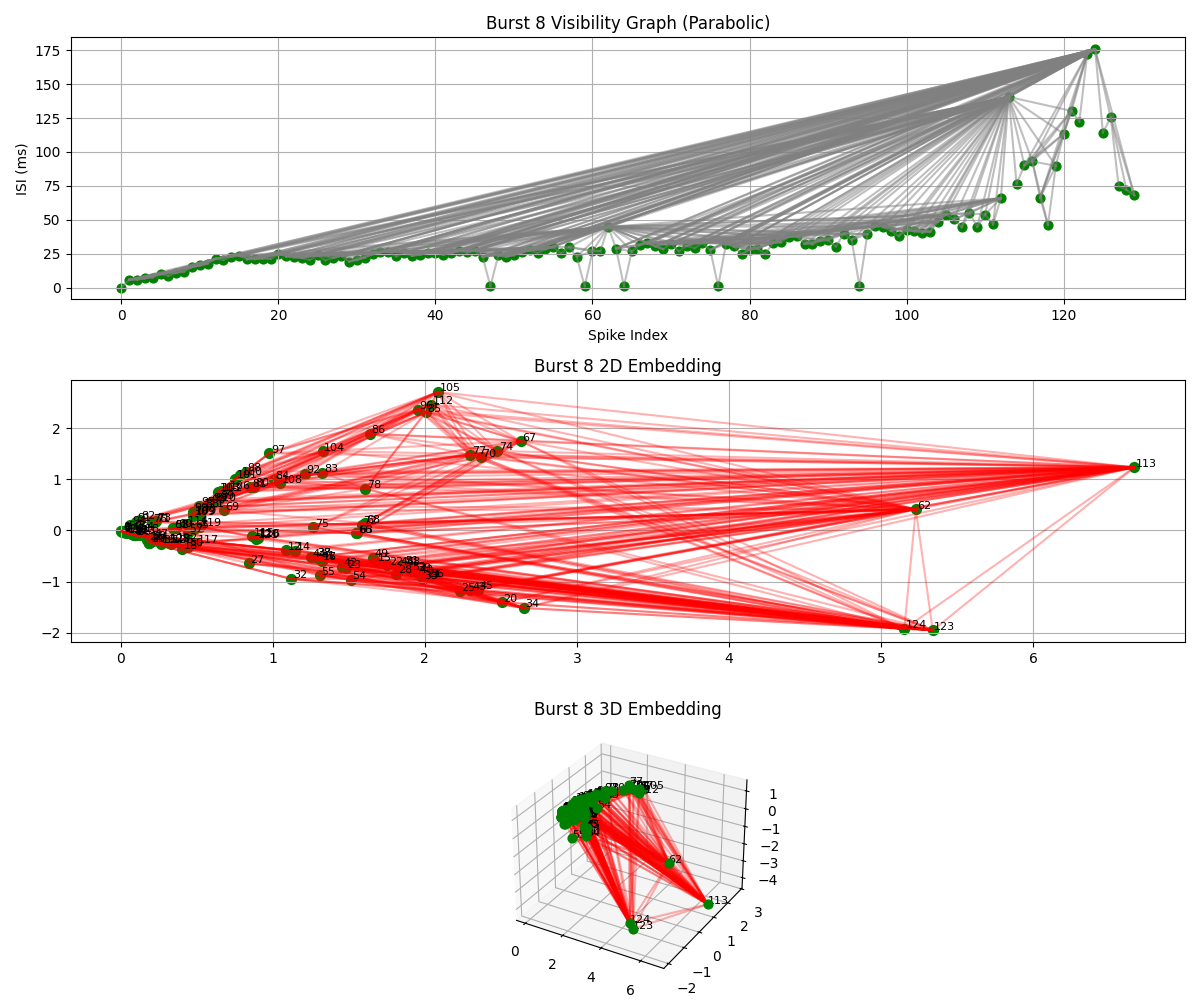

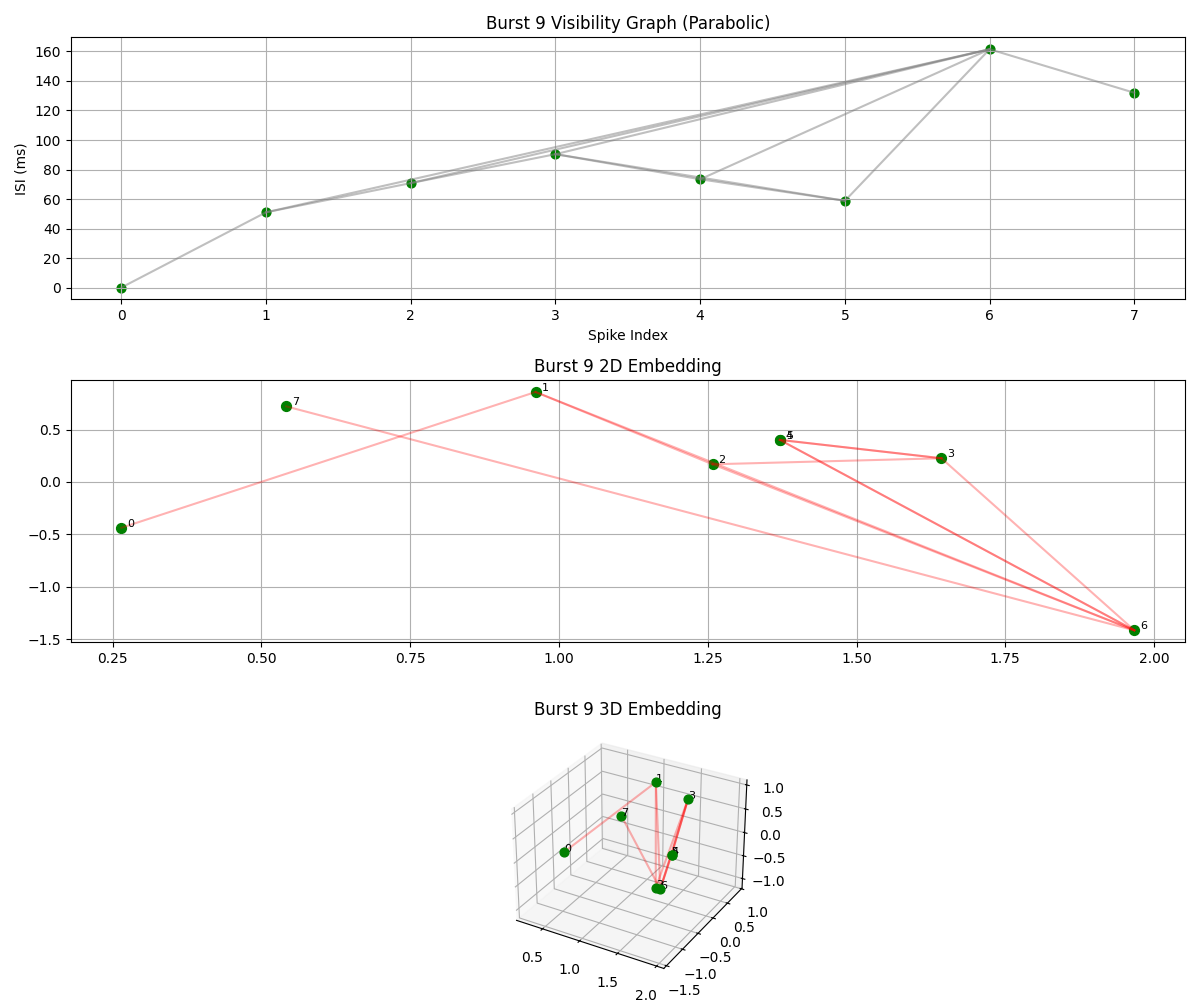

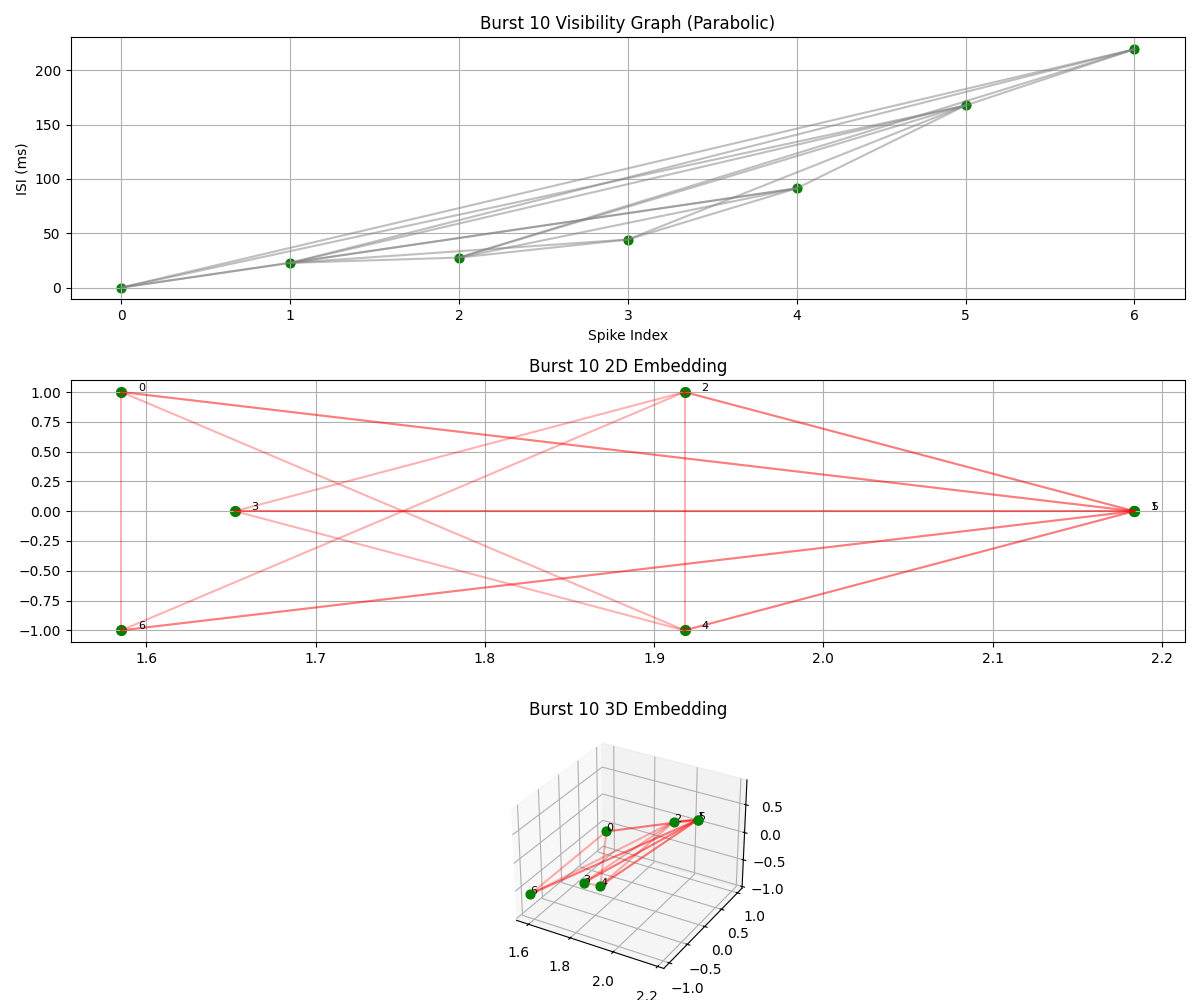

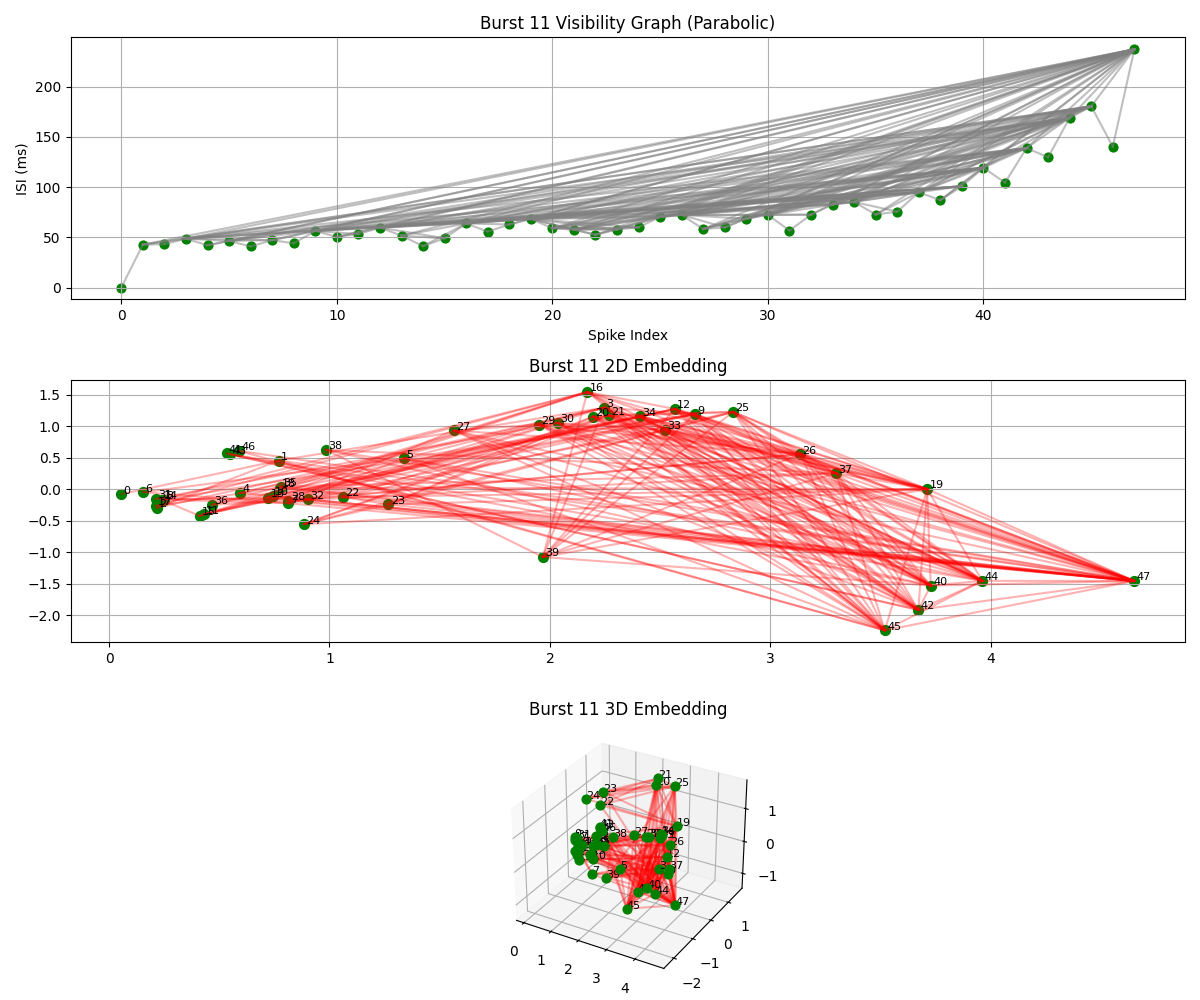

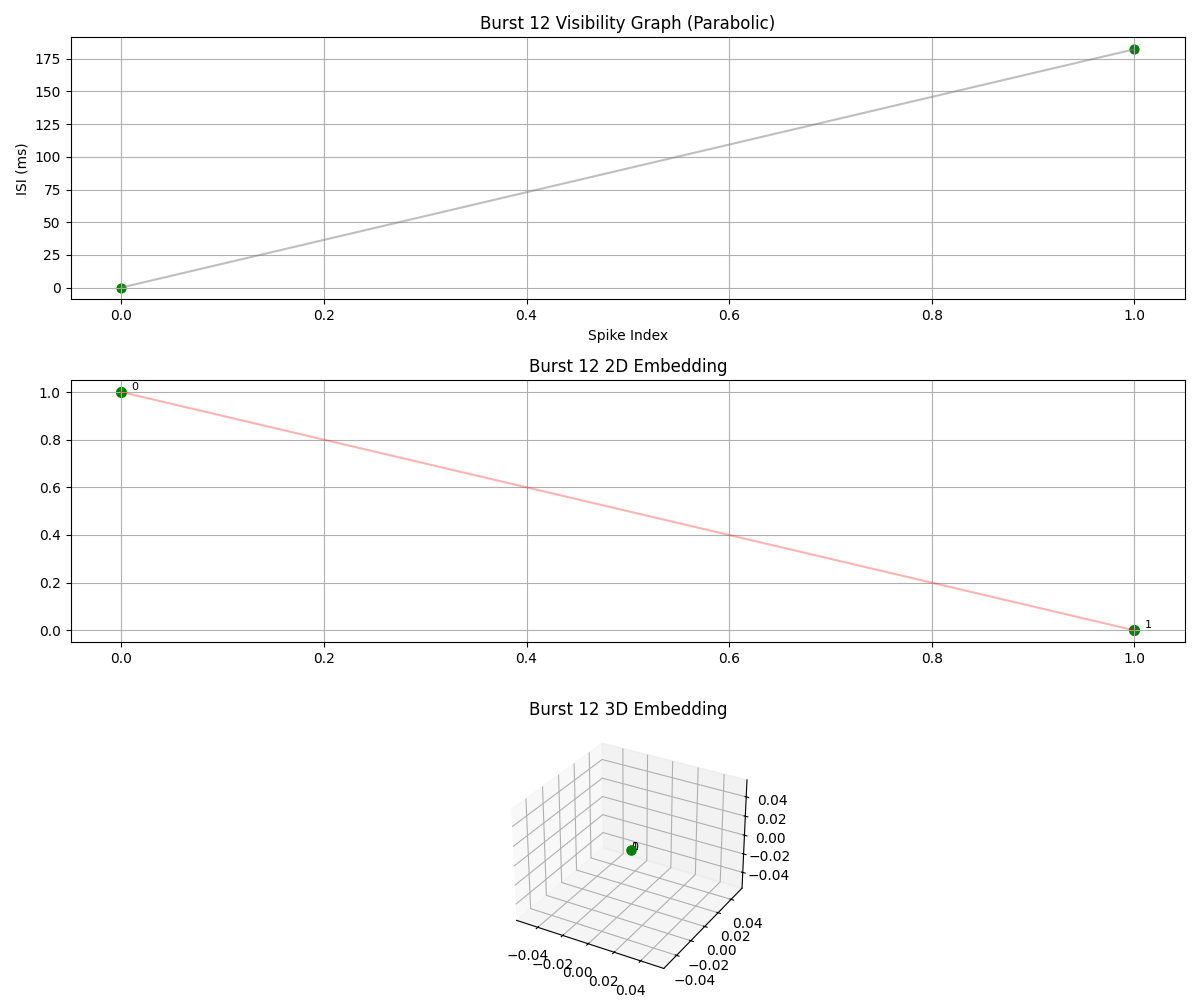

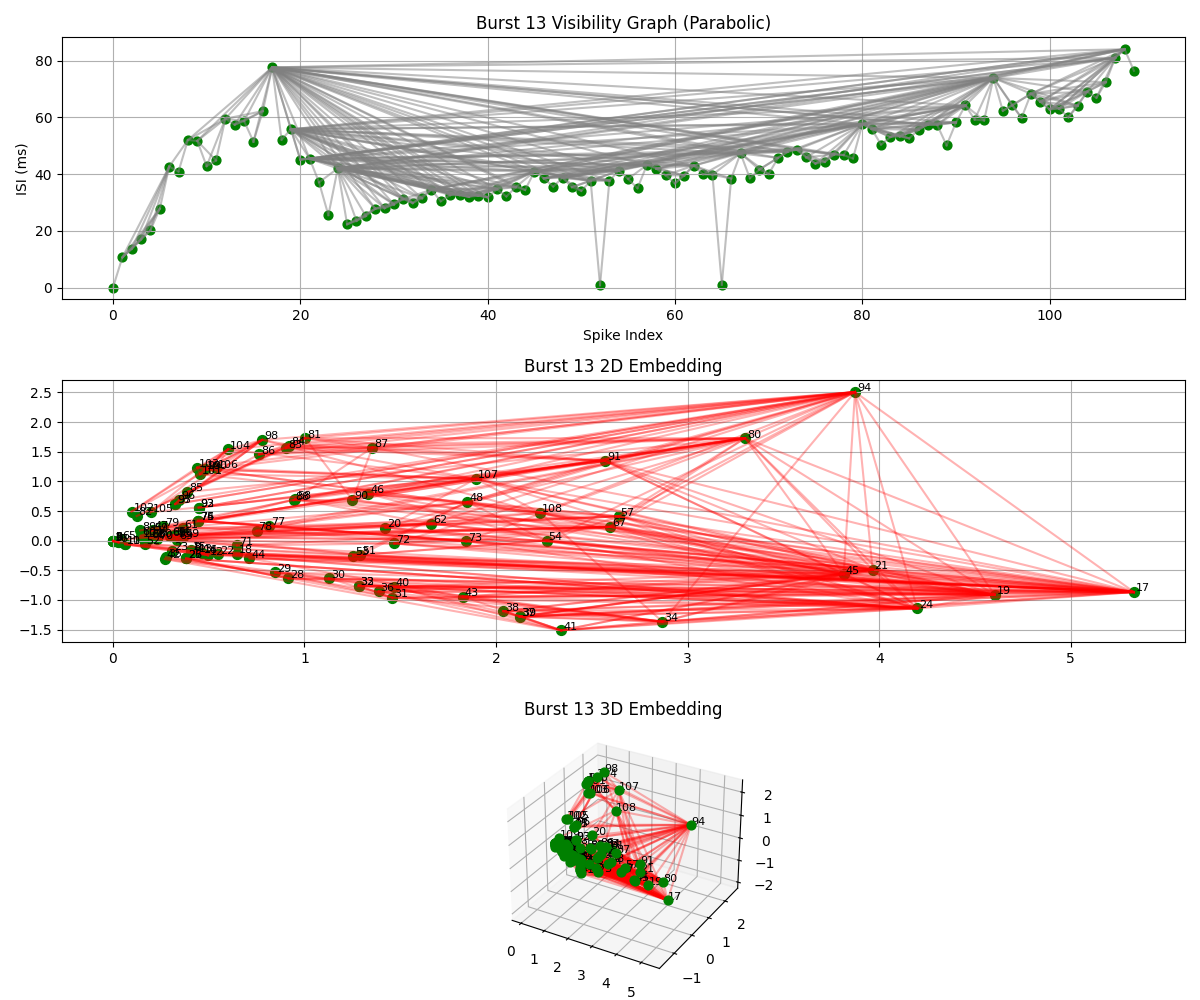

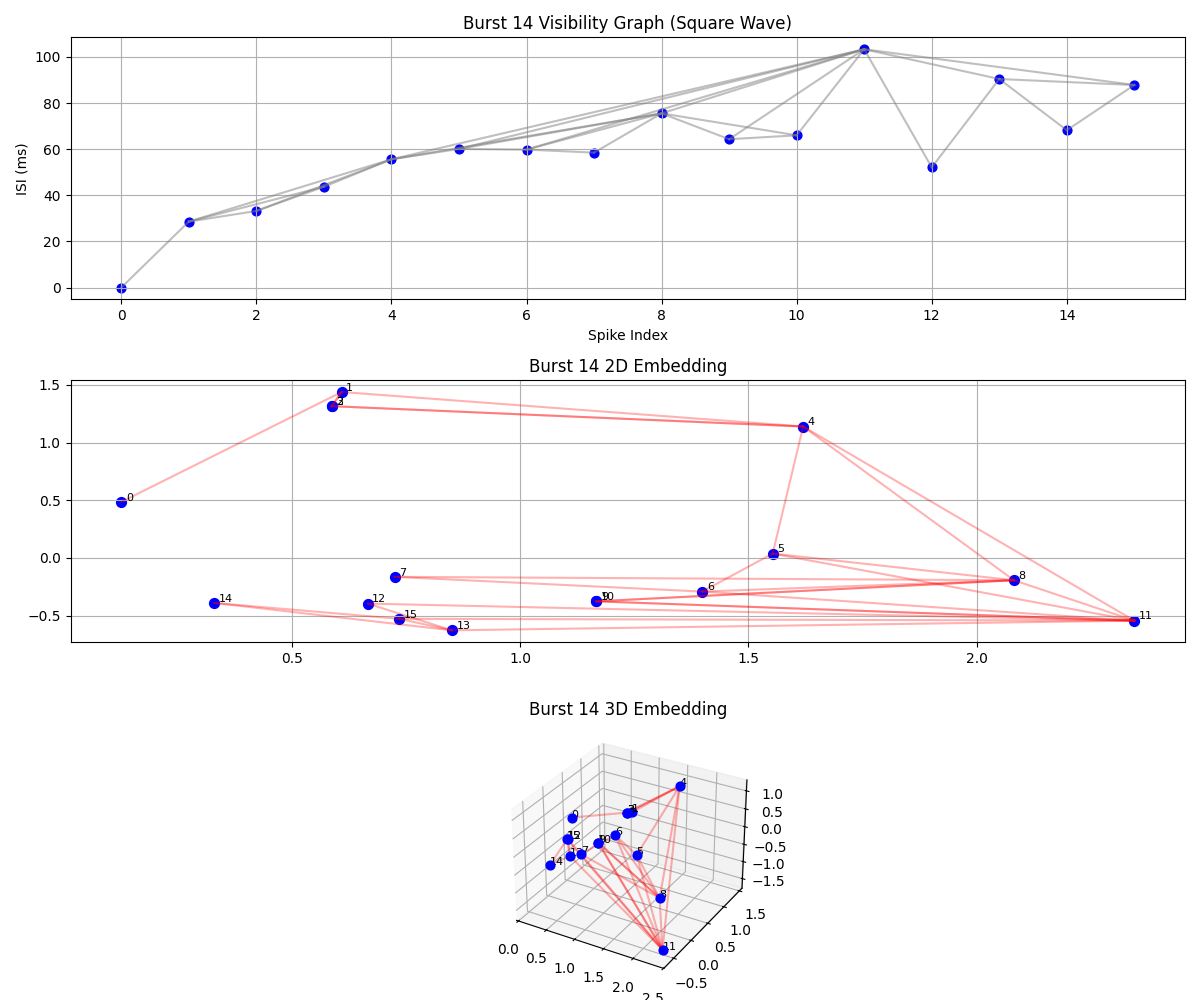

In [ ]:

df_nodes = pd.DataFrame(nodes_list, columns=[
    "Burst_Number","Type","Node_ID",
    "X_2D","Y_2D","X_3D","Y_3D","Z_3D",
    "Spike_Global_Index"
])
df_edges = pd.DataFrame(edges_list, columns=["Burst_Number","Type","Node1_ID","Node2_ID"])

df_nodes.to_csv("burst_nodes_all.csv", index=False)
df_edges.to_csv("burst_edges_all.csv", index=False)